In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [ ]:
def loadData():
    with np.load('notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# 1. Building the Computational Graph

In [ ]:
def buildGraph(alpha = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-07):

  # Variables
  W = tf.Variable(tf.random.truncated_normal((784, 1), mean=0, stddev=0.5, dtype=tf.float64))
  b = tf.Variable(0, dtype=tf.float64)

  # Prediction Function
  @tf.function
  def pred(x):
    p = tf.matmul(x, W) + b
    p = tf.nn.sigmoid(p)
    return p

  # Placeholder (not needed for TF2)
  # x = tf.compat.v1.placeholder(tf.float64, shape=(None, 784), name='x')
  # y = tf.compat.v1.placeholder(tf.float64, shape=(None, 1), name='y')
  # reg = tf.placeholder(tf.float64, name='reg')

  # Loss object
  loss_object = tf.keras.losses.BinaryCrossentropy()
  
  # Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

  return W, b, pred, loss_object, optimizer

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

# 2. Implementing Stochastic Gradient Descent

In [ ]:
def train(batch_size = 500, alpha = 0.001,  beta1 = 0.9, beta2 = 0.999, epsilon = 1e-07):
  
  @tf.function
  def train_step(images, labels, reg = 0):
    with tf.GradientTape() as tape:
      predictions = pred(images)
      loss = loss_object(labels, predictions) + reg*tf.nn.l2_loss(W)
    W_grad, b_grad = tape.gradient(loss, [W, b])
    optimizer.apply_gradients([(W_grad, W)])
    optimizer.apply_gradients([(b_grad, b)])
    train_loss(loss)
    train_accuracy(labels, predictions)

  @tf.function
  def test_step(images, labels, reg = 0):
    predictions = pred(images)
    t_loss = loss_object(labels, predictions) + reg*tf.nn.l2_loss(W)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
  
  # load data
  x_train, x_val, x_test, y_train, y_val, y_test = loadData()
  x_train = x_train.reshape(len(y_train), -1)
  x_val = x_val.reshape(len(y_val), -1)
  x_test = x_test.reshape(len(y_test), -1)

  # create validation batch
  test_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)

  # build graph
  global W, b, pred, loss_object, optimizer
  W, b, pred, loss_object, optimizer = buildGraph()

  # storing training results
  t_loss, t_acc, v_loss, v_acc = [], [], [], []
  
  EPOCHS = 700

  for epoch in range(EPOCHS):
    # reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    # Reshuffle training set for each epoch
    train_ds = tf.data.Dataset.from_tensor_slices(
      (x_train, y_train)).shuffle(3500).batch(batch_size)
    
    for images, labels in train_ds:
      train_step(images, labels)

    for test_images, test_labels in test_ds:
      test_step(test_images, test_labels)

    # print(
    #   f'Epoch {epoch + 1}, '
    #   f'Loss: {train_loss.result()}, '
    #   f'Accuracy: {train_accuracy.result() * 100}, '
    #   f'Test Loss: {test_loss.result()}, '
    #   f'Test Accuracy: {test_accuracy.result() * 100}'
    # )

    t_loss.append(train_loss.result().numpy())
    t_acc.append(train_accuracy.result().numpy())
    v_loss.append(test_loss.result().numpy())
    v_acc.append(test_accuracy.result().numpy())
  
  # plot
  plt.plot(range(1,EPOCHS+1), t_loss, label="Training")
  plt.plot(range(1,EPOCHS+1), v_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.plot(range(1,EPOCHS+1), t_acc, label="Training")
  plt.plot(range(1,EPOCHS+1), v_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuarcy")
  plt.legend()
  plt.show()

  f_train_acc = t_acc[-1]
  f_val_acc = v_acc[-1]
  test_accuracy.reset_states()
  predictions = pred(x_test)
  f_test_acc = test_accuracy(y_test, predictions)

  return f_train_acc, f_val_acc, f_test_acc.numpy()

# 3. Batch Size Investigation

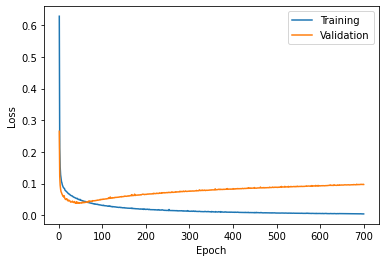

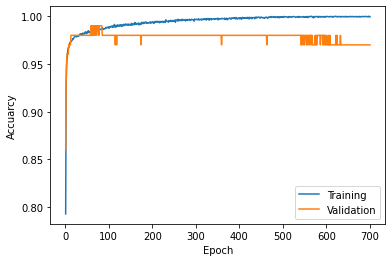

The final train, validation, test accuracy for batch size = 100 is:  0.9994286 0.97 0.9724138


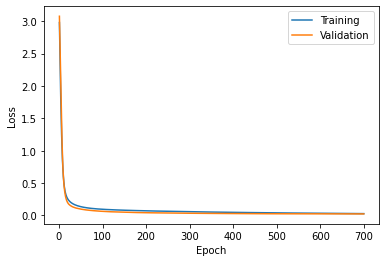

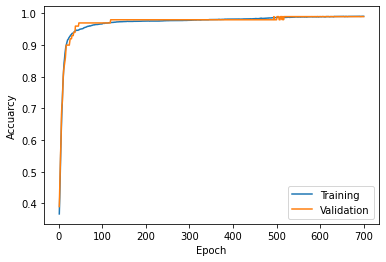

The final train, validation, test accuracy for batch size = 700 is:  0.9908571 0.99 0.99310344


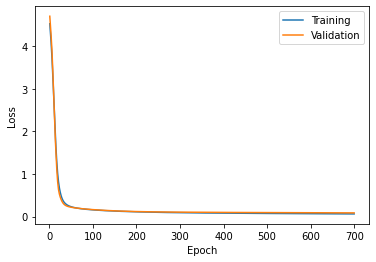

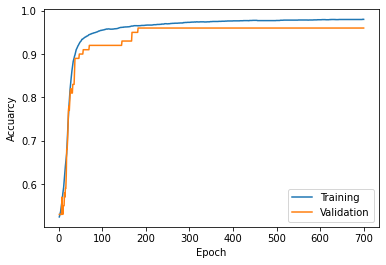

The final train, validation, test accuracy for batch size = 1750 is:  0.98 0.96 0.9655172


In [ ]:
for ba in [100,700,1750]:
  a, b, c = train(batch_size=ba)
  print("The final train, validation, test accuracy for batch size = " + (str) (ba) + " is: ", a, b, c)

Discussion: Batch size controls how often the parameter of the model will be changed. The batch size that results in the best validation accuracy is 700, therefore 700 is the batch size we will choose. Training with batch size 100 shows a sign of overfitting and train with batch size 1750 shows a sign of underfitting, therefore their performce is not as good as 700 batch size

# 4. Hyperparameter Investigation

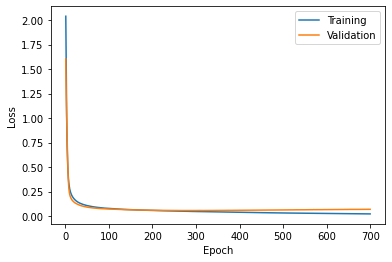

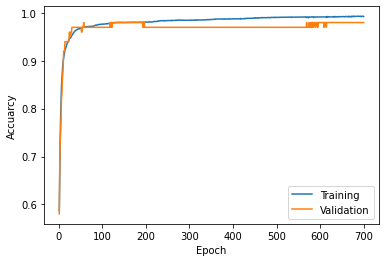

The final train, validation, test accuracy for beta1 = 0.95 is:  0.9925714 0.98 0.97931033


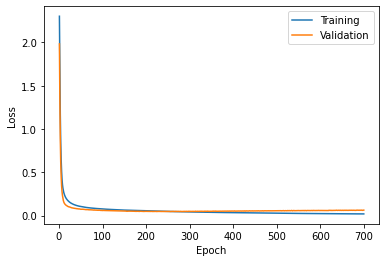

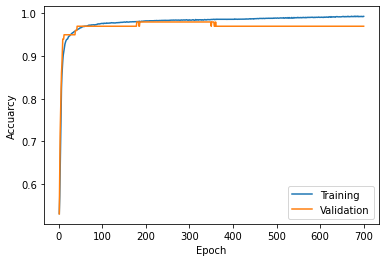

The final train, validation, test accuracy for beta1 = 0.99 is:  0.99314284 0.97 0.97931033


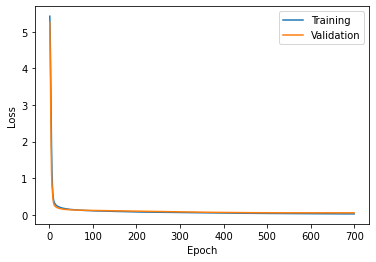

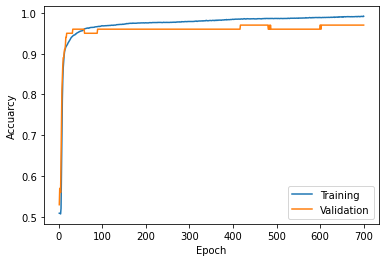

The final train, validation, test accuracy for beta2 = 0.99 is:  0.9917143 0.97 0.9862069


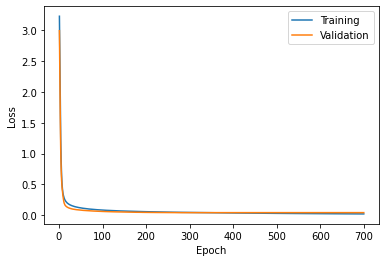

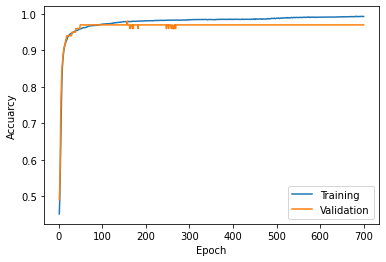

The final train, validation, test accuracy for beta2 = 0.9999 is:  0.99314284 0.97 0.9724138


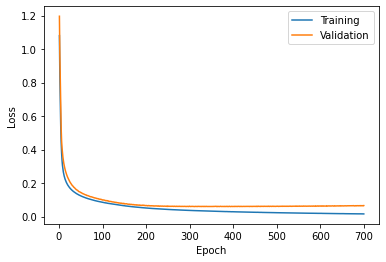

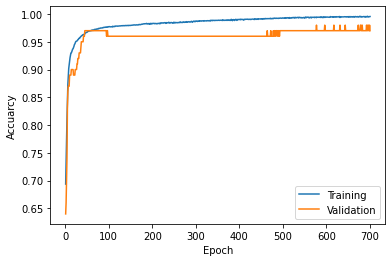

The final train, validation, test accuracy for epsilon = 1e-09 is:  0.99542856 0.97 0.97931033


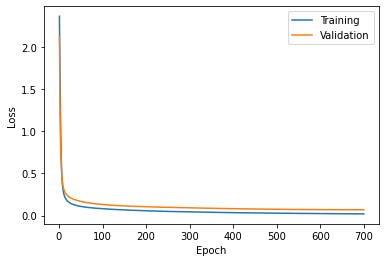

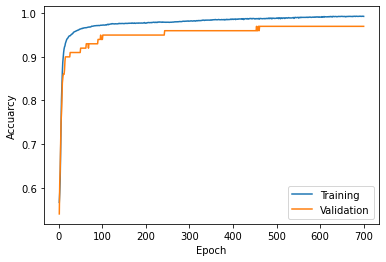

The final train, validation, test accuracy for epsilon = 0.0001 is:  0.99285716 0.97 0.97931033


In [ ]:
for b1 in [0.95,0.99]:
  a, b, c = train(beta1=b1)
  print("The final train, validation, test accuracy for beta1 = " + (str) (b1) + " is: ", a, b, c)

for b2 in [0.99,0.9999]:
  a, b, c = train(beta2=b2)
  print("The final train, validation, test accuracy for beta2 = " + (str) (b2) + " is: ", a, b, c)

for e in [1e-9, 1e-4]:
  a, b, c = train(epsilon=e)
  print("The final train, validation, test accuracy for epsilon = " + (str) (e) + " is: ", a, b, c)

Discussion: When changing beta1=0.95 and keep the other two as the default TensorFlow initialization results the best validation accuracy, therefore this is the model we will choose

# 5. Comparison against Batch GD
Discussion: The overall performance of between Adam and the batch gradient descent algorithm is very similar, both algorithm is able to report a test accuracy around 98%. However, Adam is able to train the model much faster, and converge to a consistence validation performance faster than the batch gradient descent.